In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [73]:
# Loading the 2025 property assessment data
df_2025 = pd.read_csv("fy2025-property-assessment.csv", low_memory=False)

# Checking basic info of the data set
print(f"Original dataset: {df_2025.shape[0]} rows, {df_2025.shape[1]} columns")

Original dataset: 183445 rows, 66 columns


In [74]:
# We have to fix the total value variable
# --> Remove commas in numbers and converting to numerical
df_2025['TOTAL_VALUE'] = df_2025['TOTAL_VALUE'].astype(str).str.replace(',', '').replace('nan', '0').astype(float)

# Check the target variable
print("TOTAL_VALUE statistics:")
print(df_2025['TOTAL_VALUE'].describe())

TOTAL_VALUE statistics:
count    1.834450e+05
mean     1.542565e+06
std      1.413441e+07
min      0.000000e+00
25%      3.997000e+05
50%      6.610000e+05
75%      9.843000e+05
max      2.468125e+09
Name: TOTAL_VALUE, dtype: float64


In [75]:
# Remove $0 properties (tax-exempt buildings) to clean the data
df_2025 = df_2025[df_2025['TOTAL_VALUE'] > 0]

# Filter to residential properties only (R1, R2, R3, R4, CD)
residential_types = ['R1', 'R2', 'R3', 'R4', 'CD']
df_residential = df_2025[df_2025['LU'].isin(residential_types)].copy()

# Handle missing values in key features
df_model = df_residential.copy()

# Fill missing values with median/mode
df_model['LIVING_AREA'] = df_model['LIVING_AREA'].fillna(df_model['LIVING_AREA'].median())
df_model['BED_RMS'] = df_model['BED_RMS'].fillna(df_model['BED_RMS'].median())
df_model['FULL_BTH'] = df_model['FULL_BTH'].fillna(df_model['FULL_BTH'].median())
df_model['YR_BUILT'] = df_model['YR_BUILT'].fillna(df_model['YR_BUILT'].median())
df_model['OVERALL_COND'] = df_model['OVERALL_COND'].fillna(df_model['OVERALL_COND'].mode()[0])
df_model['HLF_BTH'] = df_model['HLF_BTH'].fillna(0)
df_model['TT_RMS'] = df_model['TT_RMS'].fillna(df_model['TT_RMS'].median())
df_model['NUM_PARKING'] = df_model['NUM_PARKING'].fillna(0)

print(f"Final dataset has {len(df_model)} residential properties")

Final dataset has 136511 residential properties


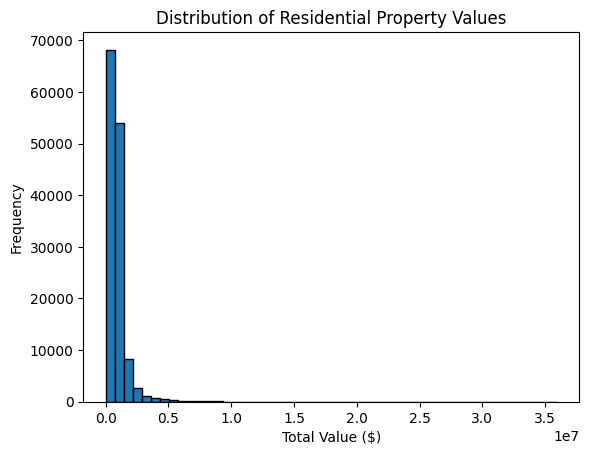

In [76]:
# Histogram for distribution of property values
plt.hist(df_model['TOTAL_VALUE'], bins=50, edgecolor='black')
plt.xlabel('Total Value ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Residential Property Values')
plt.show()

In [77]:
# Convert categorical variables to numeric for modeling
df_model['ZIP_CODE_numeric'], _ = pd.factorize(df_model['ZIP_CODE'])
df_model['CITY_numeric'], _ = pd.factorize(df_model['CITY'])
df_model['LU_numeric'], _ = pd.factorize(df_model['LU'])

# Define our feature sets
size_features = ['LIVING_AREA', 'BED_RMS', 'FULL_BTH', 'HLF_BTH', 'TT_RMS']
location_features = ['ZIP_CODE_numeric', 'CITY_numeric']
property_features = ['YR_BUILT', 'LU_numeric', 'NUM_PARKING']
combined_features = size_features + location_features + property_features

# Target variable as y
y = df_model['TOTAL_VALUE']

print("Feature sets:")
print(f"Size features ({len(size_features)}): {size_features}")
print(f"Location features ({len(location_features)}): {location_features}")
print(f"Property features ({len(property_features)}): {property_features}")
print(f"Combined features ({len(combined_features)}): {combined_features}")

Feature sets:
Size features (5): ['LIVING_AREA', 'BED_RMS', 'FULL_BTH', 'HLF_BTH', 'TT_RMS']
Location features (2): ['ZIP_CODE_numeric', 'CITY_numeric']
Property features (3): ['YR_BUILT', 'LU_numeric', 'NUM_PARKING']
Combined features (10): ['LIVING_AREA', 'BED_RMS', 'FULL_BTH', 'HLF_BTH', 'TT_RMS', 'ZIP_CODE_numeric', 'CITY_numeric', 'YR_BUILT', 'LU_numeric', 'NUM_PARKING']


In [78]:
# Model 1: Size Features Only
X_size = df_model[size_features]
X_train, X_test, y_train, y_test = train_test_split(X_size, y, test_size=0.2, random_state=42)

model_size = LinearRegression()
model_size.fit(X_train, y_train)
y_pred_size = model_size.predict(X_test)

r2_size = r2_score(y_test, y_pred_size)
print(f"Size Features Model R² Score: {r2_size:.4f}")

Size Features Model R² Score: 0.3651


In [79]:
# Model 2: Location Features Only
X_location = df_model[location_features]
X_train, X_test, y_train, y_test = train_test_split(X_location, y, test_size=0.2, random_state=42)

model_location = LinearRegression()
model_location.fit(X_train, y_train)
y_pred_location = model_location.predict(X_test)

r2_location = r2_score(y_test, y_pred_location)
print(f"Location Features Model R² Score: {r2_location:.4f}")

Location Features Model R² Score: 0.0507


In [80]:
# Model 3: Property Features Only
X_property = df_model[property_features]
X_train, X_test, y_train, y_test = train_test_split(X_property, y, test_size=0.2, random_state=42)

model_property = LinearRegression()
model_property.fit(X_train, y_train)
y_pred_property = model_property.predict(X_test)

r2_property = r2_score(y_test, y_pred_property)
print(f"Property Features Model R² Score: {r2_property:.4f}")

Property Features Model R² Score: 0.0060


In [81]:
# Model 4: Combined All Features
X_combined = df_model[combined_features]
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

model_combined = LinearRegression()
model_combined.fit(X_train, y_train)
y_pred_combined = model_combined.predict(X_test)

r2_combined = r2_score(y_test, y_pred_combined)
print(f"Combined Features Model R² Score: {r2_combined:.4f}")

Combined Features Model R² Score: 0.4068


Model Comparison:
Size Features Only: R² = 0.3651 (5 features)
Location Features Only: R² = 0.0507 (2 features)
Property Features Only: R² = 0.0060 (3 features)
Combined Features: R² = 0.4068 (10 features)


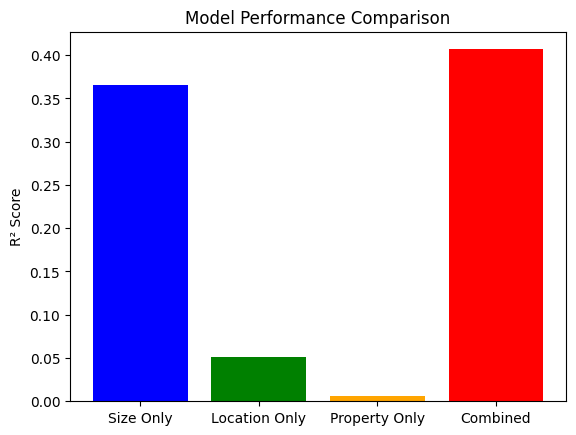

In [82]:
# Compare all models
print("Model Comparison:")
print(f"Size Features Only: R² = {r2_size:.4f} (5 features)")
print(f"Location Features Only: R² = {r2_location:.4f} ({len(location_features)} features)")
print(f"Property Features Only: R² = {r2_property:.4f} ({len(property_features)} features)")
print(f"Combined Features: R² = {r2_combined:.4f} ({len(combined_features)} features)")


# Visualize comparison
model_names = ['Size Only', 'Location Only', 'Property Only', 'Combined']
r2_scores = [r2_size, r2_location, r2_property, r2_combined]

plt.bar(model_names, r2_scores, color=['blue', 'green', 'orange', 'red'])
plt.ylabel('R² Score')
plt.title('Model Performance Comparison')
plt.show()

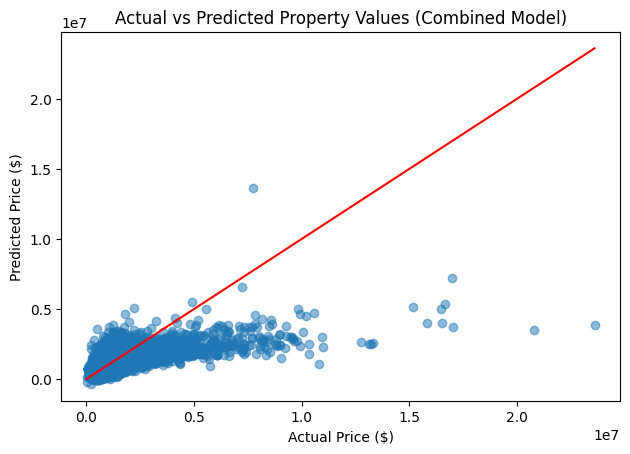

In [83]:
# Plot actual vs predicted for the best model (Combined)
plt.scatter(y_test, y_pred_combined, alpha=0.5) # Found alpha=0.5 makes the visual better by making the points transparent
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted Property Values (Combined Model)')
plt.tight_layout()
plt.show()

# Time Series Analysis (2023-2025)

In [84]:
# Load all three years of data
df_2023 = pd.read_csv("fy2023-property-assessment.csv", low_memory=False)
df_2024 = pd.read_csv("fy2024-property-assessment.csv", low_memory=False)
df_2025 = pd.read_csv("fy2025-property-assessment.csv", low_memory=False)

# Add a year column to each
df_2023['YEAR'] = 2023
df_2024['YEAR'] = 2024
df_2025['YEAR'] = 2025

# Fix TOTAL_VALUE for all three years (remove commas)
for df in [df_2023, df_2024, df_2025]:
    df['TOTAL_VALUE'] = df['TOTAL_VALUE'].astype(str).str.replace(',', '').replace('nan', '0').astype(float)

print(f"2023: {len(df_2023)} properties")
print(f"2024: {len(df_2024)} properties")
print(f"2025: {len(df_2025)} properties")

2023: 180627 properties
2024: 182242 properties
2025: 183445 properties


In [85]:
# Combine all three years into one dataset
# I looked up how to combine DataFrames and found pd.concat()
# 'ignore_index=True' renumbers the rows from 0 (part of what I found online)
df_all_years = pd.concat([df_2023, df_2024, df_2025], ignore_index=True)

print(f"Combined dataset: {len(df_all_years)} total properties")

# Clean combined data (filtering out $0 properties and filtering only residential)
df_all_years = df_all_years[df_all_years['TOTAL_VALUE'] > 0]
residential_types = ['R1', 'R2', 'R3', 'R4', 'CD']
df_all_years = df_all_years[df_all_years['LU'].isin(residential_types)].copy()

print(f"After filtering: {len(df_all_years)} residential properties across 3 years")

Combined dataset: 546314 total properties
After filtering: 405841 residential properties across 3 years


Average Property Values by Year:
2023 - Mean: $850,308, Median: $670,500
2024 - Mean: $882,300, Median: $698,700
2025 - Mean: $919,439, Median: $728,400


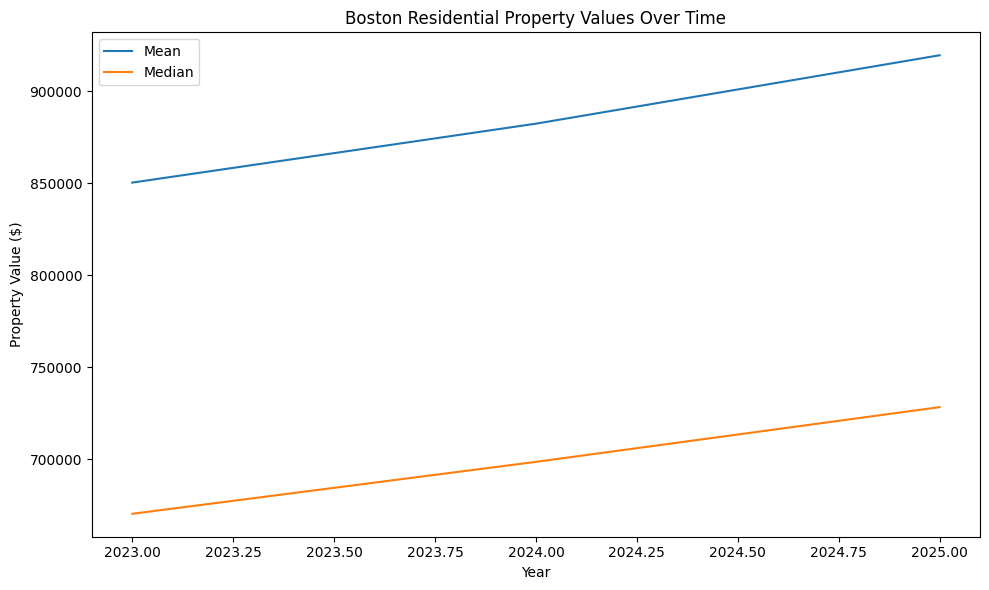

Price change from 2023 to 2025:
Mean: 8.13%
Median: 8.64%


In [86]:
# Calculate average property value by year
yearly_avg = df_all_years.groupby('YEAR')['TOTAL_VALUE'].mean()
yearly_median = df_all_years.groupby('YEAR')['TOTAL_VALUE'].median()

print("Average Property Values by Year:")
print(f"2023 - Mean: ${yearly_avg[2023]:,.0f}, Median: ${yearly_median[2023]:,.0f}")
print(f"2024 - Mean: ${yearly_avg[2024]:,.0f}, Median: ${yearly_median[2024]:,.0f}")
print(f"2025 - Mean: ${yearly_avg[2025]:,.0f}, Median: ${yearly_median[2025]:,.0f}")

# Visualize price trends over time
years = [2023, 2024, 2025]
mean_prices = [yearly_avg[2023], yearly_avg[2024], yearly_avg[2025]]
median_prices = [yearly_median[2023], yearly_median[2024], yearly_median[2025]]

plt.figure(figsize=(10, 6))
plt.plot(years, mean_prices, label='Mean')
plt.plot(years, median_prices, label='Median')
plt.xlabel('Year')
plt.ylabel('Property Value ($)')
plt.title('Boston Residential Property Values Over Time')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate percentage change from 2023 to 2025
pct_change_mean = ((yearly_avg[2025] - yearly_avg[2023]) / yearly_avg[2023]) * 100
pct_change_median = ((yearly_median[2025] - yearly_median[2023]) / yearly_median[2023]) * 100

print(f"Price change from 2023 to 2025:")
print(f"Mean: {pct_change_mean:.2f}%")
print(f"Median: {pct_change_median:.2f}%")

In [87]:
# Prepare data for modeling with YEAR as a feature
df_model_timeseries = df_all_years.copy()

# Fill missing values (same method as before)
df_model_timeseries['LIVING_AREA'] = df_model_timeseries['LIVING_AREA'].fillna(df_model_timeseries['LIVING_AREA'].median())
df_model_timeseries['BED_RMS'] = df_model_timeseries['BED_RMS'].fillna(df_model_timeseries['BED_RMS'].median())
df_model_timeseries['FULL_BTH'] = df_model_timeseries['FULL_BTH'].fillna(df_model_timeseries['FULL_BTH'].median())
df_model_timeseries['YR_BUILT'] = df_model_timeseries['YR_BUILT'].fillna(df_model_timeseries['YR_BUILT'].median())
df_model_timeseries['HLF_BTH'] = df_model_timeseries['HLF_BTH'].fillna(0)
df_model_timeseries['TT_RMS'] = df_model_timeseries['TT_RMS'].fillna(df_model_timeseries['TT_RMS'].median())
df_model_timeseries['NUM_PARKING'] = df_model_timeseries['NUM_PARKING'].fillna(0)

In [88]:
# Convert categorical variables to numeric like before
df_model_timeseries['ZIP_CODE_numeric'], _ = pd.factorize(df_model_timeseries['ZIP_CODE'])
df_model_timeseries['CITY_numeric'], _ = pd.factorize(df_model_timeseries['CITY'])
df_model_timeseries['LU_numeric'], _ = pd.factorize(df_model_timeseries['LU'])

In [89]:
# Build model with YEAR as a feature
# Add YEAR to our combined features
timeseries_features = combined_features + ['YEAR']

X_timeseries = df_model_timeseries[timeseries_features]
y_timeseries = df_model_timeseries['TOTAL_VALUE']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_timeseries, y_timeseries, test_size=0.2, random_state=42)

# Train the model
model_timeseries = LinearRegression()
model_timeseries.fit(X_train, y_train)

# Make predictions
y_pred_timeseries = model_timeseries.predict(X_test)

# Calculate R² score
r2_timeseries = r2_score(y_test, y_pred_timeseries)

print(f"Time Series Model (with YEAR) R² Score: {r2_timeseries:.4f}")
print(f"Combined Model (2025 only) R² Score: {r2_combined:.4f}")
print(f"Improvement from adding YEAR: {r2_timeseries - r2_combined:.4f}")

Time Series Model (with YEAR) R² Score: 0.4080
Combined Model (2025 only) R² Score: 0.4068
Improvement from adding YEAR: 0.0012


In [90]:
# Build model with YEAR as a feature
# Add YEAR to our combined features
timeseries_features = combined_features + ['YEAR']

X_timeseries = df_model_timeseries[timeseries_features]
y_timeseries = df_model_timeseries['TOTAL_VALUE']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_timeseries, y_timeseries, test_size=0.2, random_state=42)

# Train the model
model_timeseries = LinearRegression()
model_timeseries.fit(X_train, y_train)

# Make predictions
y_pred_timeseries = model_timeseries.predict(X_test)

# Calculate R² score
r2_timeseries = r2_score(y_test, y_pred_timeseries)

print(f"Time Series Model (with YEAR) R² Score: {r2_timeseries:.4f}")
print(f"Combined Model (2025 only) R² Score: {r2_combined:.4f}")
print(f"Improvement from adding YEAR: {r2_timeseries - r2_combined:.4f}")

Time Series Model (with YEAR) R² Score: 0.4080
Combined Model (2025 only) R² Score: 0.4068
Improvement from adding YEAR: 0.0012


In [91]:
# Compare models
print("\nFinal Model Comparison:")
print(f"Size Features Only: R² = {r2_size:.4f}")
print(f"Location Features Only: R² = {r2_location:.4f}")
print(f"Property Features Only: R² = {r2_property:.4f}")
print(f"Combined Features (2025): R² = {r2_combined:.4f}")
print(f"Combined + YEAR (2023-2025): R² = {r2_timeseries:.4f}")


Final Model Comparison:
Size Features Only: R² = 0.3651
Location Features Only: R² = 0.0507
Property Features Only: R² = 0.0060
Combined Features (2025): R² = 0.4068
Combined + YEAR (2023-2025): R² = 0.4080
